In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the libararies

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split

import torchvision
from torchvision import transforms
from torchvision.models import vgg16
from torchvision.datasets import Flowers102

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.9 MB/s eta 0:00:00


In [4]:
# import Fast Gradient Sign Method and Projected Gradient Descent
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1.Data Processing

In [6]:
# define transformer
transform = transforms.Compose([
    transforms.Resize((128,128)), # resize the images to 128*128 pixels
    transforms.ToTensor() # convert the images to a Pytorch tensor
])

In [7]:
# download train data, test data and validation data
# switch train and test splits, since test split has more data samples than train split
train_dataset = Flowers102(root='sample_data/flowers', split='test', transform=transform, download=True)
test_dataset = Flowers102(root='sample_data/flowers', split='train', transform=transform, download=True)
validation_dataset = Flowers102(root='sample_data/flowers', split='val', transform=transform, download=True)

100%|██████████| 344862509/344862509 [00:17<00:00, 20280019.59it/s]


Extracting sample_data/flowers/flowers-102/102flowers.tgz to sample_data/flowers/flowers-102


100%|██████████| 502/502 [00:00<00:00, 377878.79it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14311045.45it/s]


In [8]:
# Check the datasets
print(train_dataset)
print(test_dataset)
print(validation_dataset)

Dataset Flowers102
    Number of datapoints: 6149
    Root location: sample_data/flowers
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 1020
    Root location: sample_data/flowers
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 1020
    Root location: sample_data/flowers
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [9]:
# create dataloader to iterate over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=False, batch_size=64)

In [10]:
# Asscociate the labels and names of flowers
flower_names = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

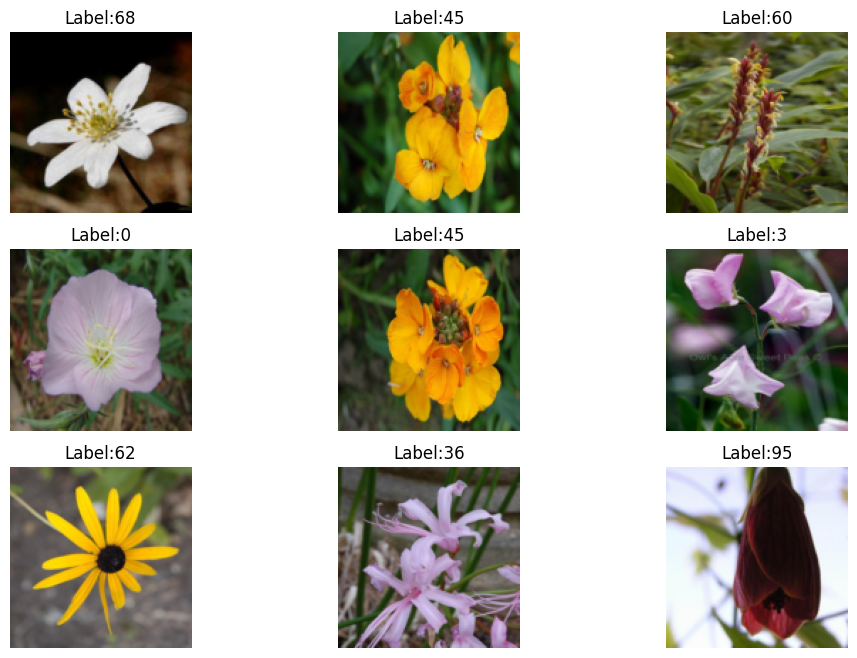

In [11]:
# plot some images and labels in train_dataloader

plt.figure(figsize=(12,8))
data = iter(train_dataloader)

for n in range(9):
    plt.subplot(3, 3, n+1)
    image, label = next(data)
    img = image[0].permute(1,2,0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str(int(label[0])))
    plt.axis('off')

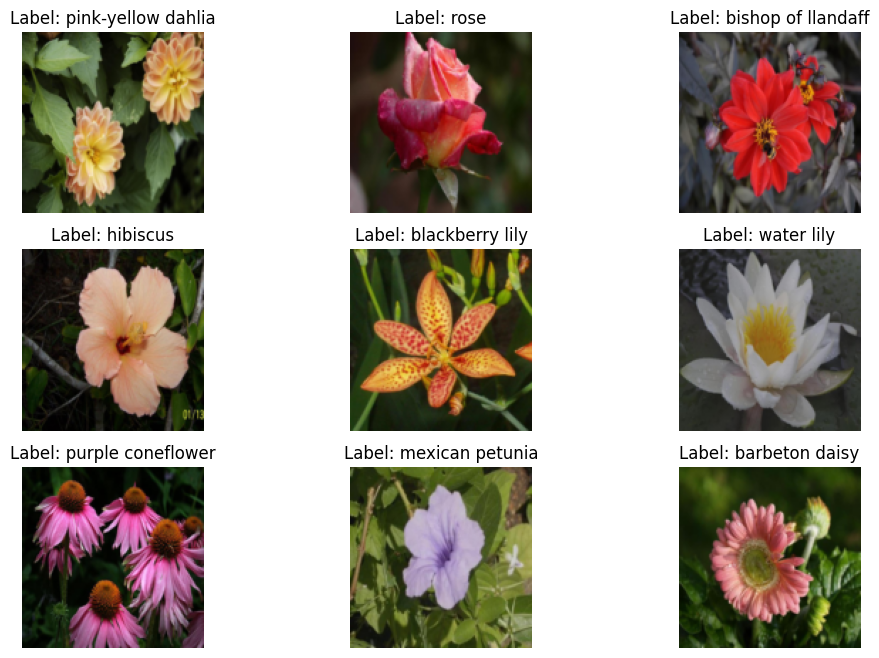

In [12]:
# plot severa images and labels
plt.figure(figsize=(12,8))

data = iter(train_dataloader)

for n in range(9):
    plt.subplot(3,3,n+1)
    image, label = next(data)
    img = image[0].permute(1,2,0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label: ' + str(flower_names.get(str(int(label[0])+1),'Unknow'))) # I increment label by 1.
    plt.axis('off')                                                             # label index still staring with 0, dictionary key starting from 1


## 2. modeling process

In [13]:
# create an object of vgg16 model

VGG16 = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 63.4MB/s]


In [14]:
VGG16.classifier._modules['6'] = nn.Linear(in_features=4096, out_features=102)
VGG16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:

#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16.parameters(), lr=0.001, momentum=0.9)

In [16]:
# Training

## define the loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16.parameters(), lr=0.001, momentum=0.9)

## define the epoch number, trainning accuracy, training loss, validation accuracy, validation loss,
epoch_number = 10
train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []

## train and validataion the model for 10 loops
for i in range(10):
    #training process
    running_loss = 0 # the total loss of every loop over all data batches
    correct = 0 # the number of the correctly predicted samples in every loop
    total = 0 # the total number of data sample in every loop
    for ktr, data in enumerate(train_dataloader,0): # for each one loop, train through all the batches
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        #forward
        outputs = VGG16(images)
        #calculate loss
        loss=criterion(outputs, labels)
        #backword
        loss.backward()
        #update parameters
        optimizer.step()

        running_loss +=loss.item() # collect total the running loss over all the batches in this loop
        total +=labels.size(0)
        _,preds = torch.max(outputs.data,1)
        correct += ((preds==labels).sum().item())
        accuracy = correct/total


    train_accuracy.append(accuracy)
    train_loss.append(running_loss)


    #validation process
    valing_loss = 0
    valing_correct = 0
    valing_total = 0
    with torch.no_grad():
        for kval, data in enumerate(validation_dataloader, 0):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            outputs = VGG16(images)
            loss = criterion(outputs, labels)

            valing_loss +=loss.item()
            valing_total +=labels.size(0)
            _, preds_val = torch.max(outputs.data,1)
            valing_correct += ((preds_val==labels).sum().item())
            acc_val = valing_correct/valing_total

    val_accuracy.append(acc_val)
    val_loss.append(valing_loss)

    print(f'{i+1}/{epoch_number}\ttraining accuracy: {accuracy:5.4f}\trunning loss: {running_loss:5.4f}\tvalidation accuracy:{acc_val:5.4f}')


1/10	training accuracy: 0.2879	running loss: 305.7557	validation accuracy:0.4020
2/10	training accuracy: 0.6773	running loss: 115.1801	validation accuracy:0.6441
3/10	training accuracy: 0.8273	running loss: 58.1520	validation accuracy:0.7461
4/10	training accuracy: 0.8914	running loss: 35.3589	validation accuracy:0.7951
5/10	training accuracy: 0.9257	running loss: 23.4251	validation accuracy:0.8069
6/10	training accuracy: 0.9476	running loss: 15.7115	validation accuracy:0.7922
7/10	training accuracy: 0.9579	running loss: 13.8069	validation accuracy:0.7873
8/10	training accuracy: 0.9162	running loss: 30.0461	validation accuracy:0.8412
9/10	training accuracy: 0.9754	running loss: 7.5082	validation accuracy:0.8549
10/10	training accuracy: 0.9816	running loss: 5.7300	validation accuracy:0.8333


Text(0.5, 1.0, 'Training Loss and Validation Loss')

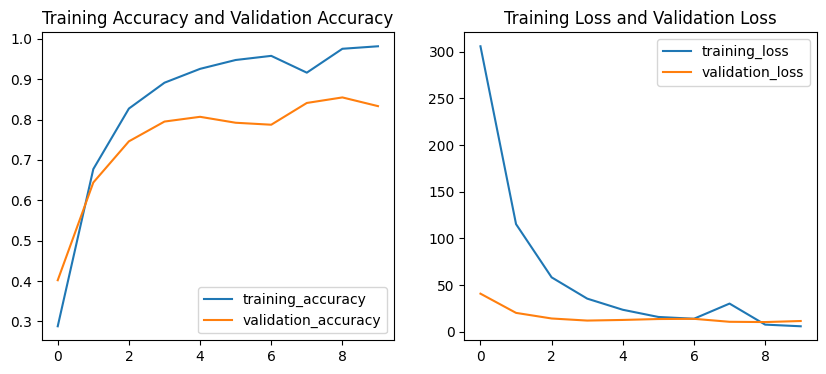

In [17]:
# plot training accuracy, validation accuracy, training loss, validation loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_accuracy, label='training_accuracy')
plt.plot(val_accuracy, label='validation_accuracy')
plt.legend()
plt.title('Training Accuracy and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(train_loss, label='training_loss')
plt.plot(val_loss, label='validation_loss')
plt.legend()
plt.title('Training Loss and Validation Loss')


In [18]:
# evaluate model on test data
test_loss = 0 # total test loss
test_total = 0 # total number of test samples
test_correct = 0 # total correctly predicted samples
with torch.no_grad():

    for i, data in enumerate(test_dataloader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        #forward
        outputs = VGG16(images)
        #loss
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_total += labels.size(0)
        _,preds_test = torch.max(outputs, 1)
        test_correct += ((preds_test == labels).sum().item())
        test_accuracy = test_correct/test_total

print('Test Accuracy: %5.4f'%(test_accuracy))


Test Accuracy: 0.8255


### 3. add adversarial attacks

In [19]:
epsilons = [0./255, 1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

In [20]:
# Fast Gradient Sign Method attack
FGSM_accuracy = [] # the list stores the accuray of each epsilon over all the data samples

fgsm_data = Subset(test_dataset, list(range(100)))
fgsm_dataloader = DataLoader(fgsm_data, batch_size=64)

for eps in epsilons:
    print('epsilon: ', eps)
    fgsm_correct = 0 # this variale stores the correctedly predicted sample for the current epsilon over all data samples
    fgsm_total = 0 # this variable stroes the total number of data samples for the current epsilon

    for data in fgsm_dataloader:
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        fgsm_imgs = fast_gradient_method(VGG16, images, eps, np.inf)
        outputs = VGG16(fgsm_imgs)
        _, fgsm_preds = torch.max(outputs,1)
        fgsm_total += labels.size(0)
        fgsm_correct += ((fgsm_preds==labels).sum().item())

        fgsm_acc = fgsm_correct/fgsm_total

    FGSM_accuracy.append(fgsm_acc)

print(FGSM_accuracy)




epsilon:  0.0
epsilon:  0.00392156862745098
epsilon:  0.011764705882352941
epsilon:  0.0196078431372549
epsilon:  0.03137254901960784
epsilon:  0.0784313725490196
epsilon:  0.19607843137254902
epsilon:  0.3137254901960784
[0.69, 0.48, 0.33, 0.27, 0.23, 0.17, 0.03, 0.02]


In [21]:
# Projected Gradient Descent attack

PGD_accuracy = []

pgd_data = Subset(test_dataset, list(range(100)))
pgd_dataloader = DataLoader(pgd_data, batch_size=64)

for eps in epsilons:
    print("epsilon: ", eps)
    pgd_correct = 0
    pgd_total = 0
    for data in pgd_dataloader:
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        pgd_imgs = projected_gradient_descent(model_fn = VGG16, x =images, eps = eps, eps_iter =2.5*eps/60, nb_iter =60, norm = np.inf)
        outputs = VGG16(pgd_imgs)
        _, pgd_preds = torch.max(outputs,1)
        pgd_correct += ((pgd_preds==labels).sum().item())
        pgd_total += labels.size(0)
        pgd_acc = pgd_correct/pgd_total

    PGD_accuracy.append(pgd_acc)

print(PGD_accuracy)


epsilon:  0.0
epsilon:  0.00392156862745098
epsilon:  0.011764705882352941
epsilon:  0.0196078431372549
epsilon:  0.03137254901960784
epsilon:  0.0784313725490196
epsilon:  0.19607843137254902
epsilon:  0.3137254901960784
[0.69, 0.31, 0.07, 0.06, 0.04, 0.05, 0.04, 0.0]


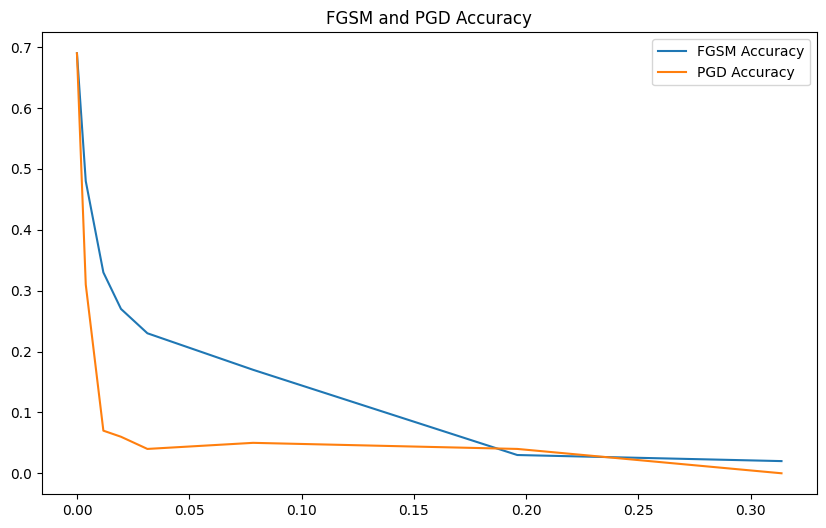

In [22]:
# Plot the test accuracy for Fast Gradient Sign Method and Projected Gradient Descent
plt.figure(figsize=(10,6))

plt.plot(epsilons, FGSM_accuracy, label='FGSM Accuracy')
plt.plot(epsilons, PGD_accuracy, label='PGD Accuracy')
plt.legend()
plt.title('FGSM and PGD Accuracy')
plt.show()

eps:  0.011764705882352941


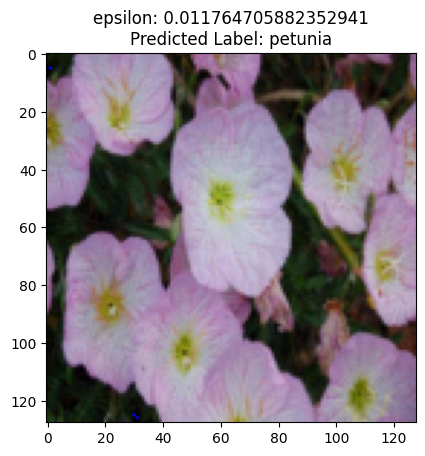

eps:  0.03137254901960784


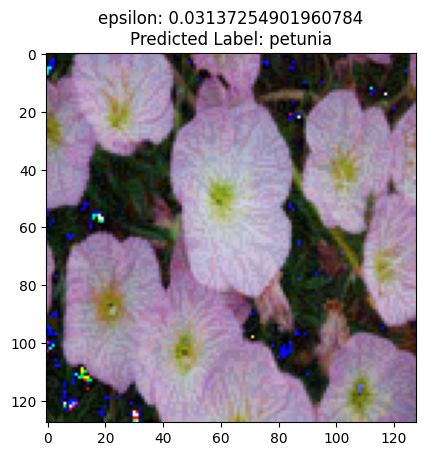

eps:  0.0784313725490196


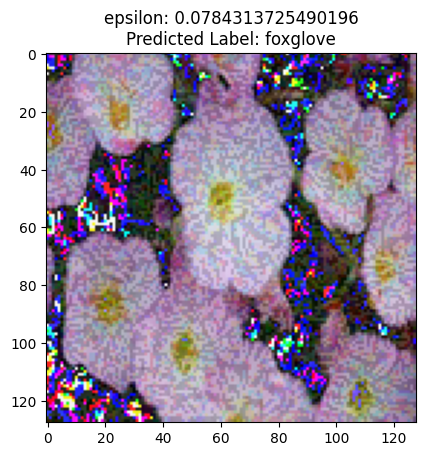

eps:  0.19607843137254902


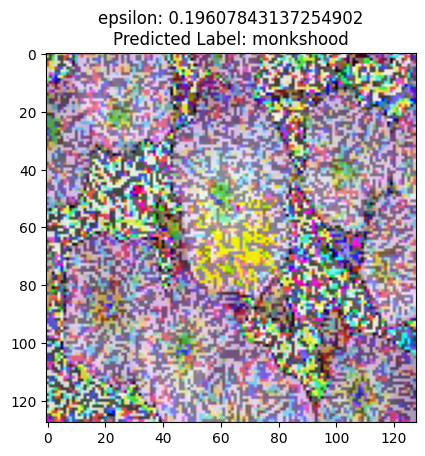

eps:  0.3137254901960784


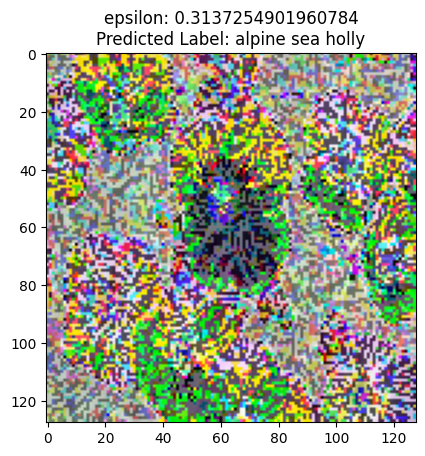

In [23]:
# plot the first image with FGSM attack on different epsilon
epsilons_1 = [3/255, 8/255, 20/255, 50/255, 80/255]

data = iter(test_dataloader)
data_fgsm = next(data)
for eps in epsilons_1:
  print('eps: ', eps)

  #data = next(data_fgsm)
  images, labels = data_fgsm
  labels = labels.type(torch.LongTensor)
  images, labels = images.to(device), labels.to(device)

  fgsm_img_1 = fast_gradient_method(VGG16, images, eps, np.inf)
  output_1 = VGG16(fgsm_img_1)
  _, fgsm_preds_1 = torch.max(output_1, 1)

  fgsm_img_1_plot = (fgsm_img_1[0].permute(1,2,0).cpu().detach().numpy()*255).astype(np.uint8)

  plt.imshow(fgsm_img_1_plot)
  fgsm_label_1 = fgsm_preds_1.cpu().detach().numpy()[0]

  plt.title('epsilon: '+ str(eps)+ '\n' + 'Predicted Label: ' + str(flower_names.get(str(int(fgsm_label_1+1)),'unknown')))
  plt.show()






### 4. report


**Table1:** Classification Accuracy

| **model** | train set | validataion set | test set |
|-----------|-----------|-----------------|----------|
|fine tune VGG16 model with Torch| 0.9816 | 0.8333  | 0.8255|

**Table 2:** Classification accuracy on clean and adversarial images

|  model  | clean images | adversarial images(1/255) | avdersarial images(5/255) | adversarial images (8/255)|
|---------|--------------|---------------------------|---------------------------|---------------------------|
|FGSM attack|   0.69     |   0.48                    |  0.27                     | 0.23                      |
|PGD attack |   0.69     |   0.31                    |  0.06                     | 0.04                      |

**Analysis**

 - 1. Adversarial pertubation has a significant impact on model accuracy, even we add some pertutaion to the originial data, the classification accuracy declines dramatically. But it also shows PGD attack has more impact than FGSM attack. Especially when purtubation increasing, the impact is also increasing. 
 - 2. Compared to FGSM and PGD libraries in Keras, when implementing the same attack from Torch cleverhans library, the model accuracy is attack more seriously. PGD attack also impact more serious than FGSM attack.   